# Feasibility of Rainy Lake Rule Curves

Under what conditions is it possible to maintain lake levels at the target levels?

The IJC Supplementary Order of 2000 set the target level for Rainy Lake at the middle of the upper and lower rule curves. Calling the target lake level $H_{target}$, it must satisfy the mass balance

$$A \frac{dH_{target}}{dt} = Q_{in} - Q_{out}$$

The combined stage-discharge charateristics of upper Rainy River and the International Falls Dam establishes an upper bound on $Q_{out}$ such that

$$Q_{out} \leq Q^{\max}_{out}(H)$$

To maintain the lake level at $H_{target}$, then

$$Q_{in} \leq  \underbrace{\frac{dH_{target}}{dt} + Q^{\max}_{out}(H_{target})}_{Q^{\max}_{in}}$$

The purpose of this notebook is to estimate ${Q^{\max}_{in}}$, then test whether historical inflows to Rainy Lake are typically within that limit.

### Initialization

In [4]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os
import datetime
import pickle

# Module to enhance matplotlib plotting
import seaborn
seaborn.set()

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Data Directory
dir = '../data/'

### Load Needed Rainy Lake Data

In [89]:
# Rainy River Flowrate
RR = pd.read_pickle(dir+'RR.pkl')

# Rainy Lake Level
RL = pd.read_pickle(dir+'RL.pkl')

# Stage-Area function for Rainy Lake
area = pd.read_pickle(dir+'area.pkl')['Rainy Lake']

# Stage-Volume function for Rainy Lake
volume = pd.read_pickle(dir+'volume.pkl')['Rainy Lake']

# Rule Curves for Rainy Lake
RL2000 = pd.read_pickle(dir+'RL2000.pkl')
RL1970 = pd.read_pickle(dir+'RL1970.pkl')

## Rainy River Discharge Characteristics

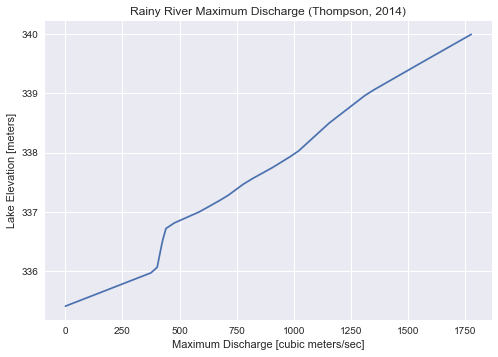

In [90]:
# Discharge Relationship (Thompson, 2014)
data = pd.DataFrame([
    [335.40,    0.0],
    [336.00,  399.0],
    [336.50,  425.0],
    [336.75,  443.0],
    [337.00,  589.0],
    [337.25,  704.0],
    [337.50,  792.0],
    [337.75,  909.0],
    [338.00, 1014.0],
    [338.50, 1156.0],
    [339.00, 1324.0],
    [339.50, 1550.0],
    [340.00, 1778.0]
])

# Create a function to compute maximum discharge as function of lake elevation
from scipy.interpolate import interp1d
Qmax = interp1d(data[0],data[1])

h = np.linspace(data[0].min(),data[0].max())
plt.plot(Qmax(h),h)
plt.xlabel('Maximum Discharge [cubic meters/sec]')
plt.ylabel('Lake Elevation [meters]')
plt.title('Rainy River Maximum Discharge (Thompson, 2014)')

Compare the maximum stage-discharge characteristics given by Thompson (2014) to historical data.

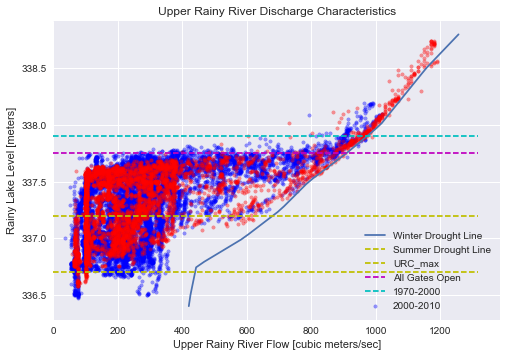

In [100]:
# Concatenate Rainy River flow and Rainy Lake level data
Q = pd.concat([RR,RL],axis=1)
Q.columns = ['RR','RL']

# Divide into two periods
A = Q.ix['1971':'2000'].index
B = Q.ix['2000':].index

# Plot two periods
plt.scatter(Q['RR'][A],Q['RL'][A],marker='.',color='b',alpha=0.4)
plt.scatter(Q['RR'][B],Q['RL'][B],marker='.',color='r',alpha=0.4)

# plot maximum discharge curve
h = np.linspace(336.4,338.8)
plt.plot(Qmax(h),h)
plt.plot()

# Add rule curve landmarks
ax = plt.axis()
plt.plot([ax[0],ax[1]],[336.70,336.70],'y--')
plt.plot([ax[0],ax[1]],[337.20,337.20],'y--')
plt.plot([ax[0],ax[1]],[337.75,337.75],'m--')
plt.plot([ax[0],ax[1]],[337.90,337.90],'c--')

# annotate
plt.xlabel('Upper Rainy River Flow [cubic meters/sec]')
plt.ylabel('Rainy Lake Level [meters]')
plt.title('Upper Rainy River Discharge Characteristics')
ax = plt.axis()
plt.axis([0,ax[1],ax[2],ax[3]])
plt.legend(['Winter Drought Line',
            'Summer Drought Line',
            'URC_max',
            'All Gates Open',
            '1970-2000',
            '2000-2010'],
           loc="lower right")

# Save plot
fname = '../images/RainyRiverDischarge_Thompson.png'
plt.savefig(fname)
!convert $fname -trim $fname

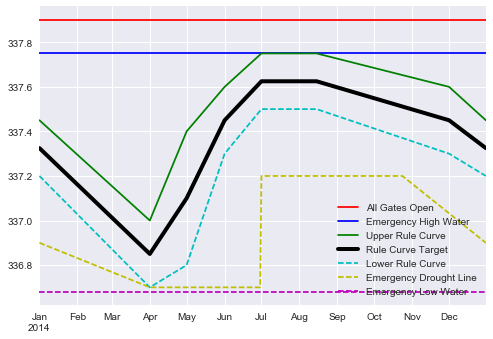

In [101]:
plt.subplot()

RL2000['AGO'].plot(style='r')
RL2000['EHW'].plot(style='b')
RL2000['URC'].plot(style='g')
((RL2000['LRC'] + RL2000['URC'])/2.0).plot(style='k',linewidth=4)
RL2000['LRC'].plot(style='c--')
RL2000['EDL'].plot(style='y--')
RL2000['ELW'].plot(style='m--')

plt.legend(['All Gates Open',
            'Emergency High Water',
            'Upper Rule Curve',
            'Rule Curve Target',
            'Lower Rule Curve',
            'Emergency Drought Line',
            'Emergency Low Water'],
           loc='lower right')


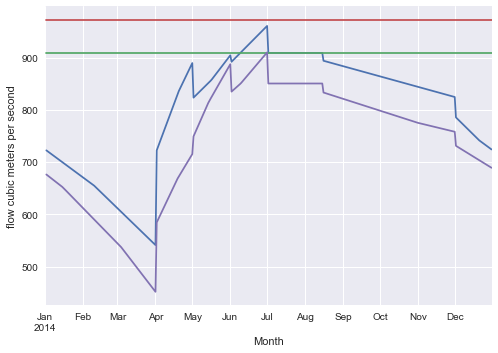

In [102]:
H = RL2000.copy()
H.drop('LRC',1,inplace=True)
H.drop('EDL',1,inplace=True)
H.drop('ELW',1,inplace=True)
H['Target'] = (RL2000['LRC'] + RL2000['URC'])/2.0

for key in H.keys():
    (H[key].map(Qmax) + (1000000.0/86400.0)*H[key].map(volume).diff()).plot()
plt.xlabel('Month')
plt.ylabel('flow cubic meters per second')

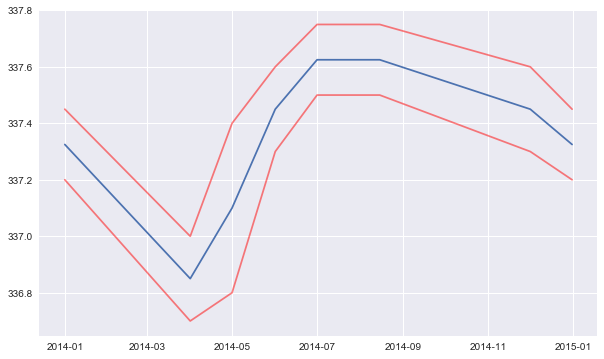

In [103]:
Hset = 0.5*(RL2000['URC'] + RL2000['LRC'])

plt.figure(figsize=(10,6))
axes = plt.subplot()

plt.plot(RL2000.index,RL2000['URC'],color='r',alpha=0.5,axes=axes)
plt.plot(RL2000.index,RL2000['LRC'],color='r',alpha=0.5,axes=axes)
plt.plot(Hset.index,Hset)

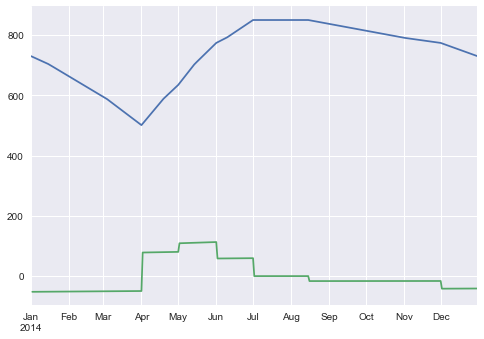

In [104]:
Qnet = Hset.map(volume).diff()*(1000000.0/86400.0)
Qout = Hset.map(Qmax)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.subplot()
Qout.plot()
Qnet.plot()

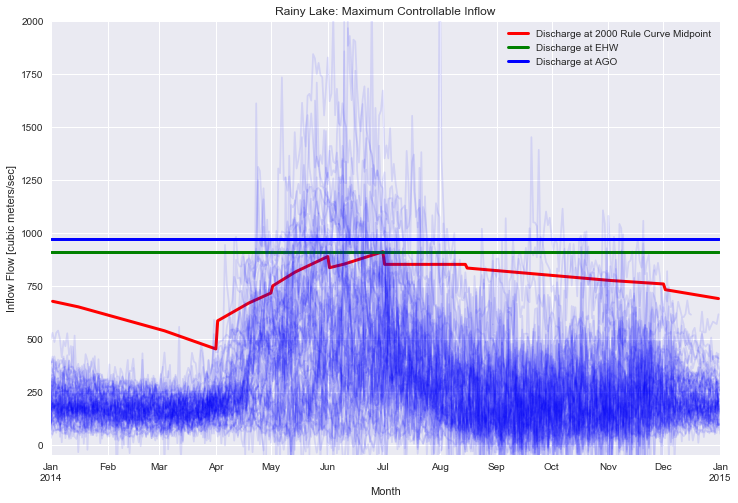

In [144]:
Imax = Qout+Qnet

plt.figure(figsize=(12,8))

Imax.plot(color='r',lw=3)
H['AGO'].map(Qmax).plot(color='b',lw=3)

Inflow = RR + RL.map(volume).diff()*1000000.0/86400.0

for (yr,r) in Inflow['1948':].groupby(Inflow['1948':].index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot(color='b',alpha=0.1).legend([' '])
    
plt.xlabel('Month')
plt.ylabel('Inflow Flow [cubic meters/sec]')
plt.title('Rainy Lake: Maximum Controllable Inflow')
plt.ylim([-50,2000])
plt.legend(['Discharge at 2000 Rule Curve Midpoint','Discharge at EHW','Discharge at AGO'])


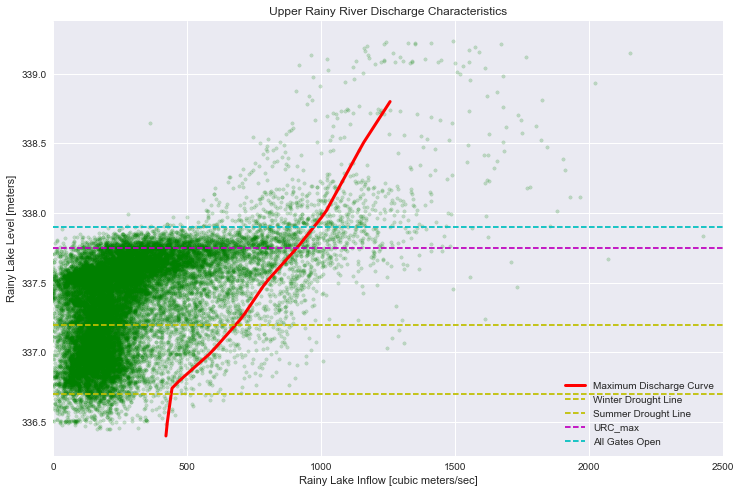

In [136]:
Inflow = RR + RL.map(volume).diff()*1000000.0/86400.0

R = pd.concat([RL,Inflow],axis=1)
R.columns = ['Level','Inflow']
idx = R['1948':].index

plt.figure(figsize=(12,8))
plt.scatter(R['Inflow'][idx], R['Level'][idx], marker='.', color='g', alpha=0.2)
plt.xlim(0,2500)

# plot maximum discharge curve
h = np.linspace(336.4,338.8)
plt.plot(Qmax(h),h,color='r',lw=3)
plt.plot()

# Add rule curve landmarks
ax = plt.axis()
plt.plot([ax[0],ax[1]],[336.70,336.70],'y--')
plt.plot([ax[0],ax[1]],[337.20,337.20],'y--')
plt.plot([ax[0],ax[1]],[337.75,337.75],'m--')
plt.plot([ax[0],ax[1]],[337.90,337.90],'c--')

# annotate
plt.xlabel('Rainy Lake Inflow [cubic meters/sec]')
plt.ylabel('Rainy Lake Level [meters]')
plt.title('Upper Rainy River Discharge Characteristics')
ax = plt.axis()
plt.axis([0,ax[1],ax[2],ax[3]])
plt.legend(['Maximum Discharge Curve',
            'Winter Drought Line',
            'Summer Drought Line',
            'URC_max',
            'All Gates Open'],
           loc="lower right")


In [146]:
R['1948':].head()

,Level,Inflow
1948-01-01,337.728,222.246187
1948-01-02,337.728,286.000000
1948-01-03,337.724,258.753813
1948-01-04,337.718,238.162224
1948-01-05,337.715,280.095289
